In [1]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d
import cv2
import math
import csv
import copy
import os

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
LiDAR_data = './raw_data/2022-12-10-16-53-36_Velodyne-VLP-16-Data.csv'

os.path.exists(LiDAR_data)

True

In [3]:
with open(LiDAR_data, newline='') as f:
    rows = list(csv.reader(f, delimiter=',', quotechar='"'))
    sph_lidar = np.zeros(shape=(len(rows) - 1, 3))
    headers = rows.pop(0)
    for index, row in enumerate(rows[1:]):
        # print(index, row[0])
        sph_lidar[index] = row[7:10]

In [4]:
indexer = {
    0:15,
    2:14,
    4:13,
    6:12,
    8:11,
    10:10,
    12:9,
    14:8,
    1:7,
    3:6,
    5:5,
    7:4,
    9:3,
    11:2,
    13:1,
    15:0,
}

sph_lidar[:,0] = np.array(list(map(indexer.get, sph_lidar[:,0])))

In [5]:
target_shape = tuple(sph_lidar[:,:2].astype(int).max(axis=0)[:2] + 1)
sph_lidar_frame = np.zeros(target_shape)
sph_lidar_frame[sph_lidar[:,0].astype(int),sph_lidar[:,1].astype(int)]=sph_lidar[:,2]

apply papoulish gerchberg

(16, 36000)
17555
17398
172


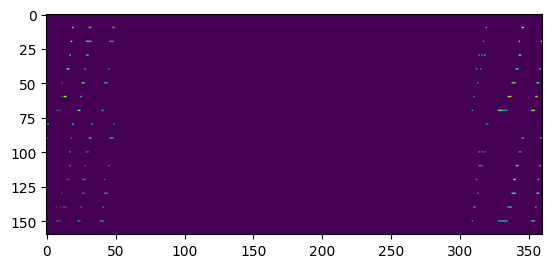

In [6]:

print(target_shape)
print(np.count_nonzero(sph_lidar[:,2]))
print(np.count_nonzero(sph_lidar_frame))

m = 160//16
us = np.zeros((160,360))
us[::m,:] = sph_lidar_frame[:,::100]
print(np.count_nonzero(us))

plt.imshow(us)

In [7]:
def lpf(img, ncutoff):
    # Apply 2D FFT to the image
    f = np.fft.fft2(img)

    # Shift the zero frequency component to the center of the spectrum
    fshift = np.fft.fftshift(f)

    # Create a circular mask of the same size as the spectrum
    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.uint8)
    cutoff = int(min(crow, ccol)*ncutoff)
    axes = (5, 10)
    cv2.circle(mask, (ccol, crow), cutoff, 1, -1)
    # cv2.ellipse(mask, (ccol, crow), axes, 0, 0, 360,  1, -1)

    # Apply the mask to the shifted spectrum
    fshift_filtered = fshift * mask

    # Shift the zero frequency component back to the corner of the spectrum
    f_filtered = np.fft.ifftshift(fshift_filtered)

    # Apply the inverse 2D FFT to the filtered spectrum
    img_filtered = np.fft.ifft2(f_filtered)
    img_filtered = np.real(img_filtered)

    return img_filtered


def pg(input, us_rate, ncutoff, gt_mean, threshold = 100):
# def pg(input, us_rate, ncutoff, gt_mean, iter):

    pg_mean = 0
    filtered = input
    
    while pg_mean * 1.1 < gt_mean and threshold > 0:
    # for i in range(iter):
        filtered = lpf(filtered,ncutoff)
        filtered[::us_rate, ::us_rate] = input[::us_rate, ::us_rate]
        pg_mean = filtered.mean()
        threshold -=1
    
    return filtered

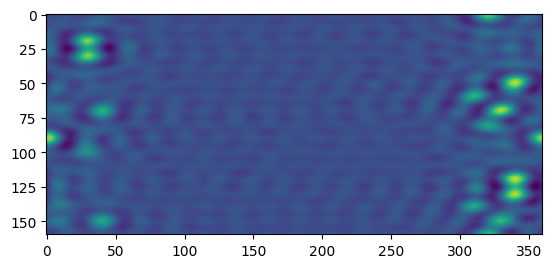

In [8]:
gt_mean = sph_lidar_frame[sph_lidar_frame>0].mean()

pg_frame = pg(us, m, 0.2, gt_mean=gt_mean, threshold=1000)
plt.imshow(pg_frame)

In [9]:
def back_to_pts_form(arr):
    # get the shape of the input array
    m, n = arr.shape
    
    # create a 3D output array of size (m * n, 3)
    out = np.zeros((m * n, 3))
    
    # populate the output array
    for i in range(m):
        for j in range(n):
            index = i * n + j
            out[index, 0] = arr[i, j]
            out[index, 1] = i
            out[index, 2] = j
    
    return out


In [10]:
angle = {
    15:-15,
    14:-13,
    13:-11,
    12:-9,
    11:-7,
    10:-5,
    9:-3,
    8:-1,
    7:1,
    6:3,
    5:5,
    4:7,
    3:9,
    2:11,
    1:13,
    0:15,
}

In [11]:
back_pts = back_to_pts_form(pg_frame)
back_pts[:,1] = np.array(list(map(angle.get, back_pts[:,1])))
back_pts[:,1] = np.radians(back_pts[:,1])
back_pts[:,2] = np.radians(back_pts[:,2])

In [12]:
np.savetxt("back_pts.txt", back_pts)

In [13]:
point_cloud_data = back_pts

# Convert spherical coordinates to Cartesian coordinates
x = point_cloud_data[:, 0] * np.cos(point_cloud_data[:, 1]) * np.cos(point_cloud_data[:, 2])
y = point_cloud_data[:, 0] * np.cos(point_cloud_data[:, 1]) * np.sin(point_cloud_data[:, 2])
z = point_cloud_data[:, 0] * np.sin(point_cloud_data[:, 1])

pg_pts = np.asarray([x, y, z]).T

pcd_pg_lidar = o3d.geometry.PointCloud()
pcd_pg_lidar.points = o3d.utility.Vector3dVector(pg_pts)

In [14]:
sph_lidar[:,0] = np.radians(sph_lidar[:,0])
sph_lidar[:,1] = np.radians(sph_lidar[:,1] / 100)

point_cloud_data = sph_lidar

# Convert spherical coordinates to Cartesian coordinates
x = point_cloud_data[:, 2] * np.cos(point_cloud_data[:, 0]) * np.cos(point_cloud_data[:, 1])
y = point_cloud_data[:, 2] * np.cos(point_cloud_data[:, 0]) * np.sin(point_cloud_data[:, 1])
z = point_cloud_data[:, 2] * np.sin(point_cloud_data[:, 0])

inp_pts = np.asarray([x, y, z]).T

pcd_inp_lidar = o3d.geometry.PointCloud()
pcd_inp_lidar.points = o3d.utility.Vector3dVector(inp_pts)

In [15]:
pcd_pg_lidar.paint_uniform_color([1, 0.706, 0])
pcd_inp_lidar.paint_uniform_color([1, 0, 0])

PointCloud with 17556 points.

In [16]:

o3d.visualization.draw_geometries([pcd_pg_lidar, pcd_inp_lidar])